In [176]:
import numpy as np
import pandas as pd
import mne
import glob
import os
from scipy.signal import resample
from matplotlib import pyplot as plt
from idun_sdk import do_bandpass, prepare_fft
from data_labeler import calculate_bad_epochs
from scipy.signal import find_peaks
import copy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from utils.lag_calculator import calculate_lag, epoch_data, remove_outliers, replace_outliers,calculate_epochs_lag

### Variables

In [237]:
FILTER_RANGE = [20,40]
BASE_SAMPLE_RATE = 250

FIRST_LAG_EPOCH_SIZE = BASE_SAMPLE_RATE * 60
SECOND_LAG_EPOCH_SIZE = BASE_SAMPLE_RATE * 30 # 30 works best
TOTAL_LINEAR_SEGMENTS = 200

### Upload data

In [238]:
edf_file_path = glob.glob(os.path.join("data", '*.edf'))[0]
csv_file_path = glob.glob(os.path.join("data", '*.csv'))[0]

prodigy_raw_data = mne.io.read_raw_edf(edf_file_path, preload=True)

# upload csv file using numpy
idun_raw_data = np.genfromtxt(csv_file_path, delimiter=',', skip_header=1)

### Unpack prodigy

In [239]:
CHANNEL_1 = "LEFT_EYE"
CHANNEL_2 = "RIGHT_EYE"
PRODIGY_SAMPLE_RATE = 120
prodigy_data, prodigy_times = prodigy_raw_data[:, :]
prodigy_channel_names = prodigy_raw_data.ch_names

# find the position of the channels in channel_names
channel_1_index = prodigy_channel_names.index(CHANNEL_1)
channel_2_index = prodigy_channel_names.index(CHANNEL_2)
# extract the data from the channels
prodigy_channel_1_data = prodigy_data[channel_1_index, :]
prodigy_channel_2_data = prodigy_data[channel_2_index, :]
# minus right eye from left eye
prodigy_channel_1_minus_2 = prodigy_channel_1_data - prodigy_channel_2_data
prodigy_channel_1_minus_2 = prodigy_channel_1_minus_2*1000000

# Upsample to 250 Hz
num_samples_250 = int(BASE_SAMPLE_RATE/PRODIGY_SAMPLE_RATE*len(prodigy_channel_1_minus_2))
resampled_prodigy_data = resample(prodigy_channel_1_minus_2, num_samples_250)

# Filter
prodigy_filtered_data_rs = do_bandpass(resampled_prodigy_data,  [FILTER_RANGE[0], FILTER_RANGE[1]], BASE_SAMPLE_RATE)
resampled_times = np.linspace(0, len(prodigy_filtered_data_rs)/BASE_SAMPLE_RATE, len(prodigy_filtered_data_rs))

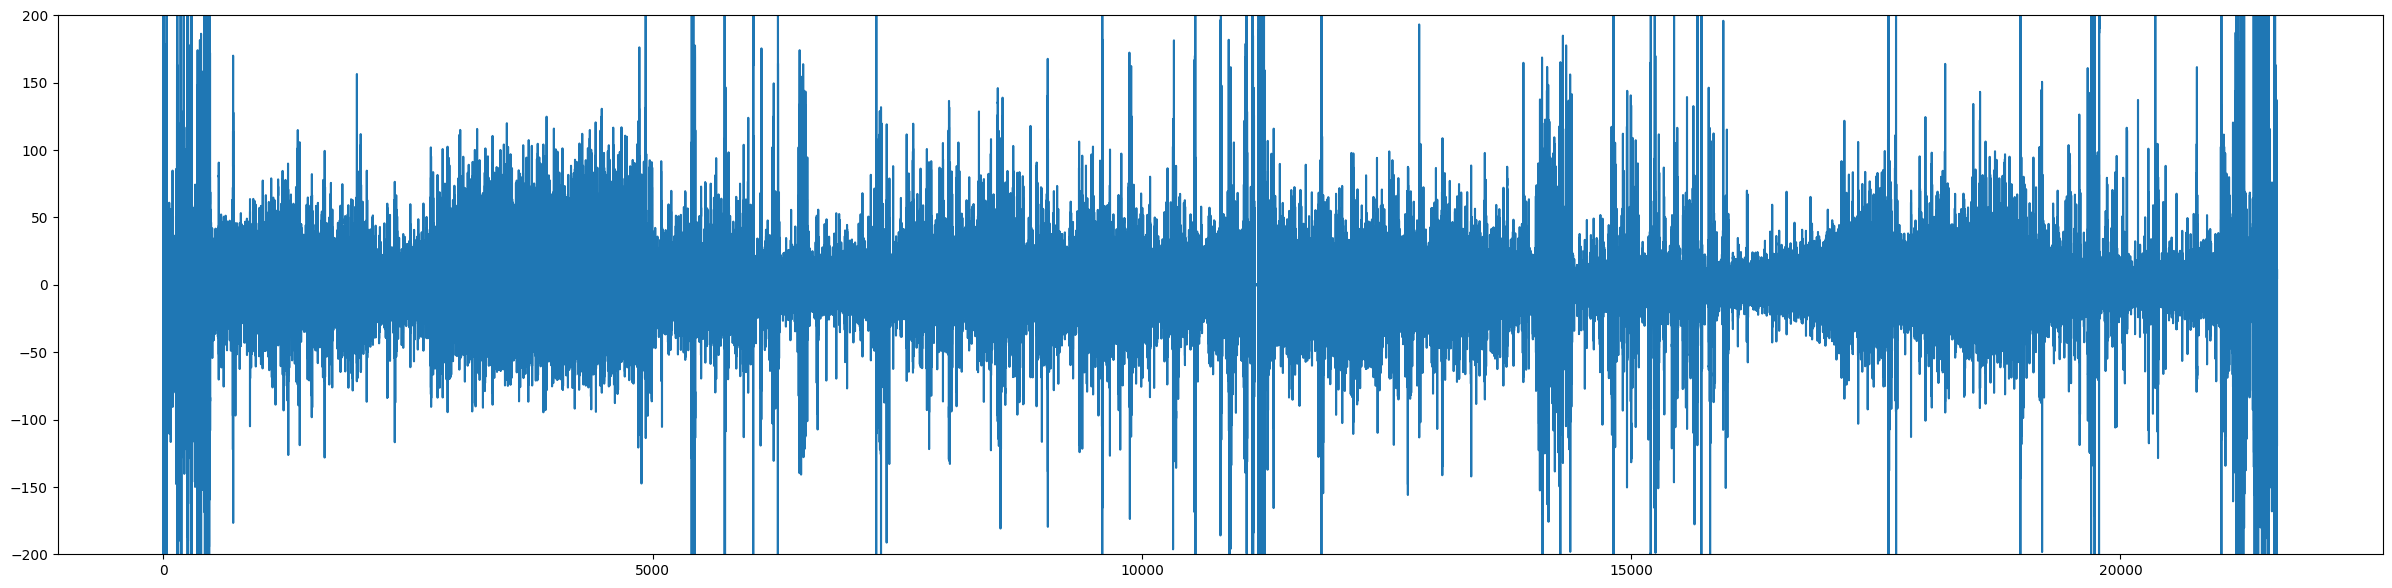

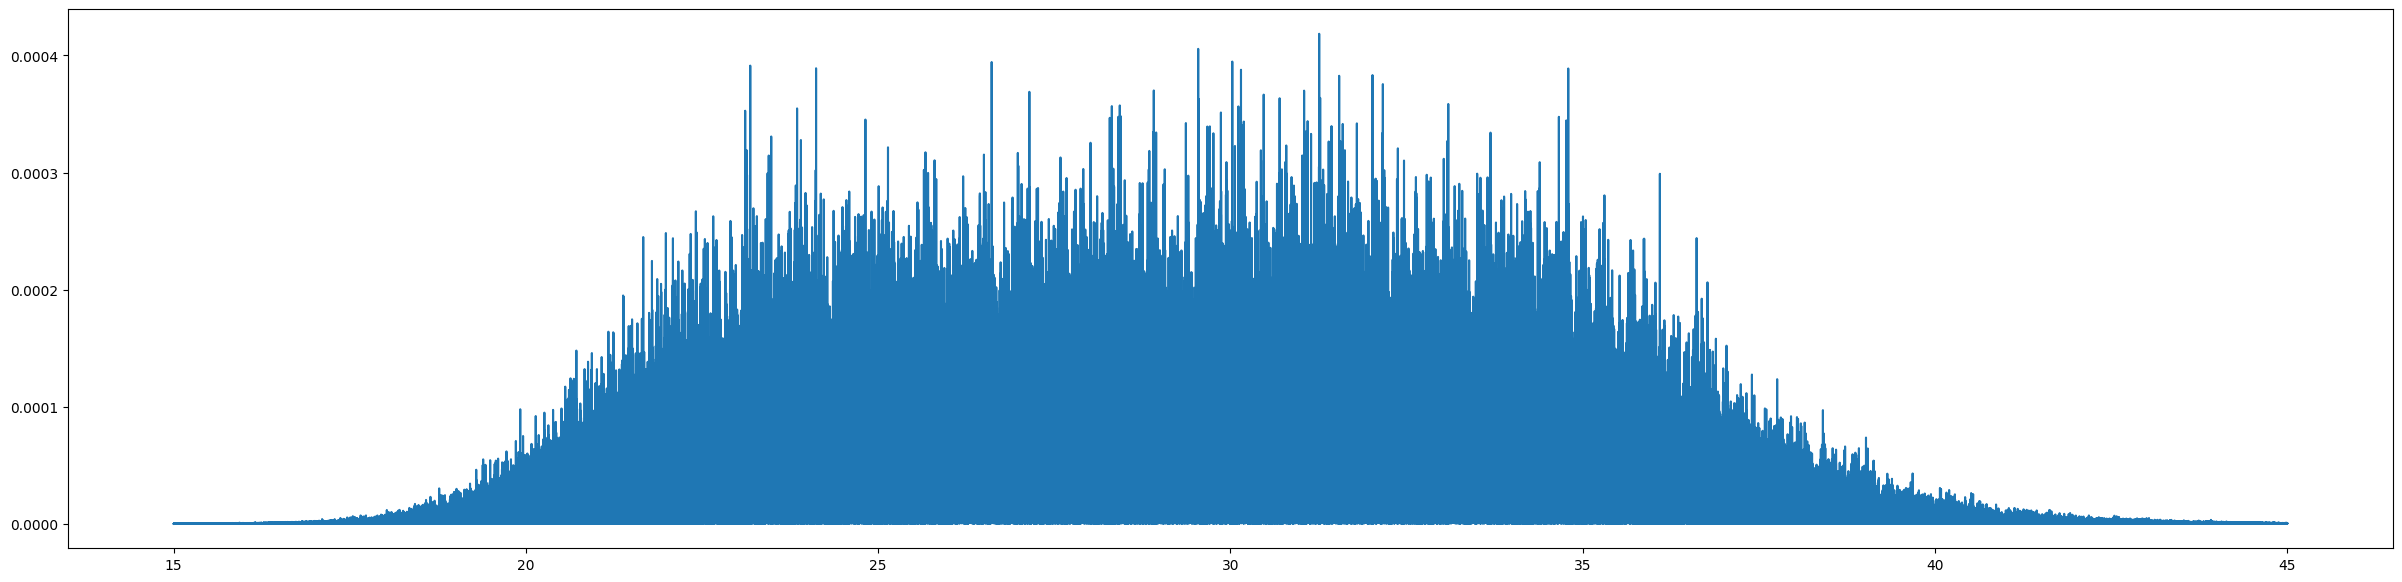

In [240]:
plt.figure(figsize=(30, 7))
plt.plot(resampled_times, resampled_prodigy_data)
plt.ylim(-200, 200)

pr_freqs_rs, pr_fft_rs = prepare_fft(prodigy_filtered_data_rs, FILTER_RANGE[0]-5 ,FILTER_RANGE[1]+5, BASE_SAMPLE_RATE)
plt.figure(figsize=(30, 7))
plt.plot(pr_freqs_rs, pr_fft_rs)

### Unpack IDUN

In [241]:
IDUN_SAMPLE_RATE = 250
idun_data = idun_raw_data[:,1]
idun_time_stamps = idun_raw_data[:,0]
idun_time_stamps = idun_time_stamps - idun_time_stamps[0]

# bandpass filter
idun_filtered_data = do_bandpass(idun_data, [FILTER_RANGE[0], FILTER_RANGE[1]], IDUN_SAMPLE_RATE)


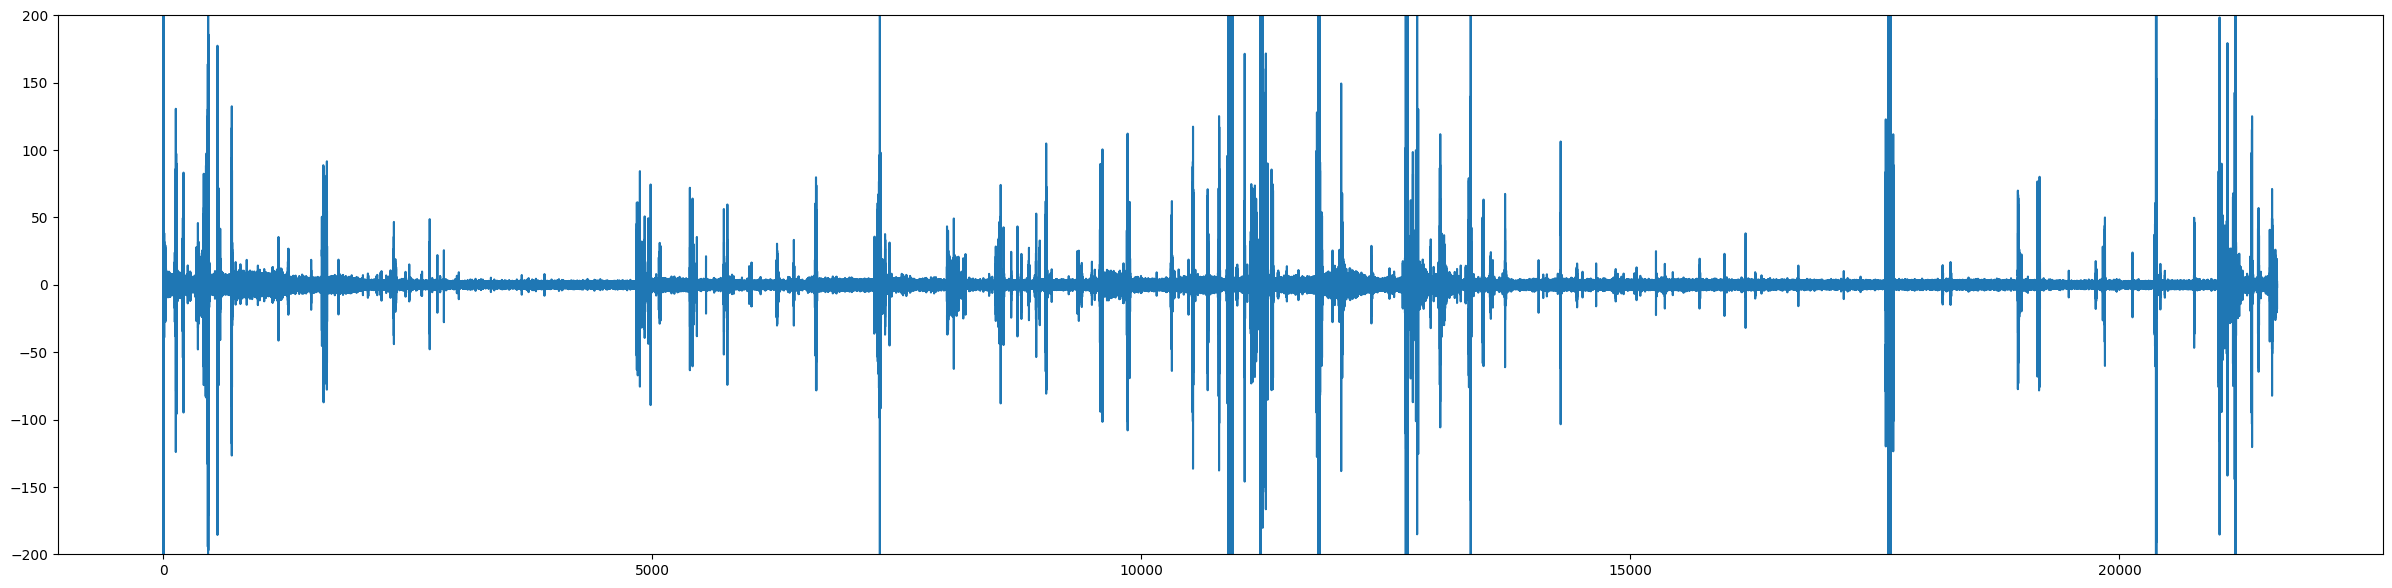

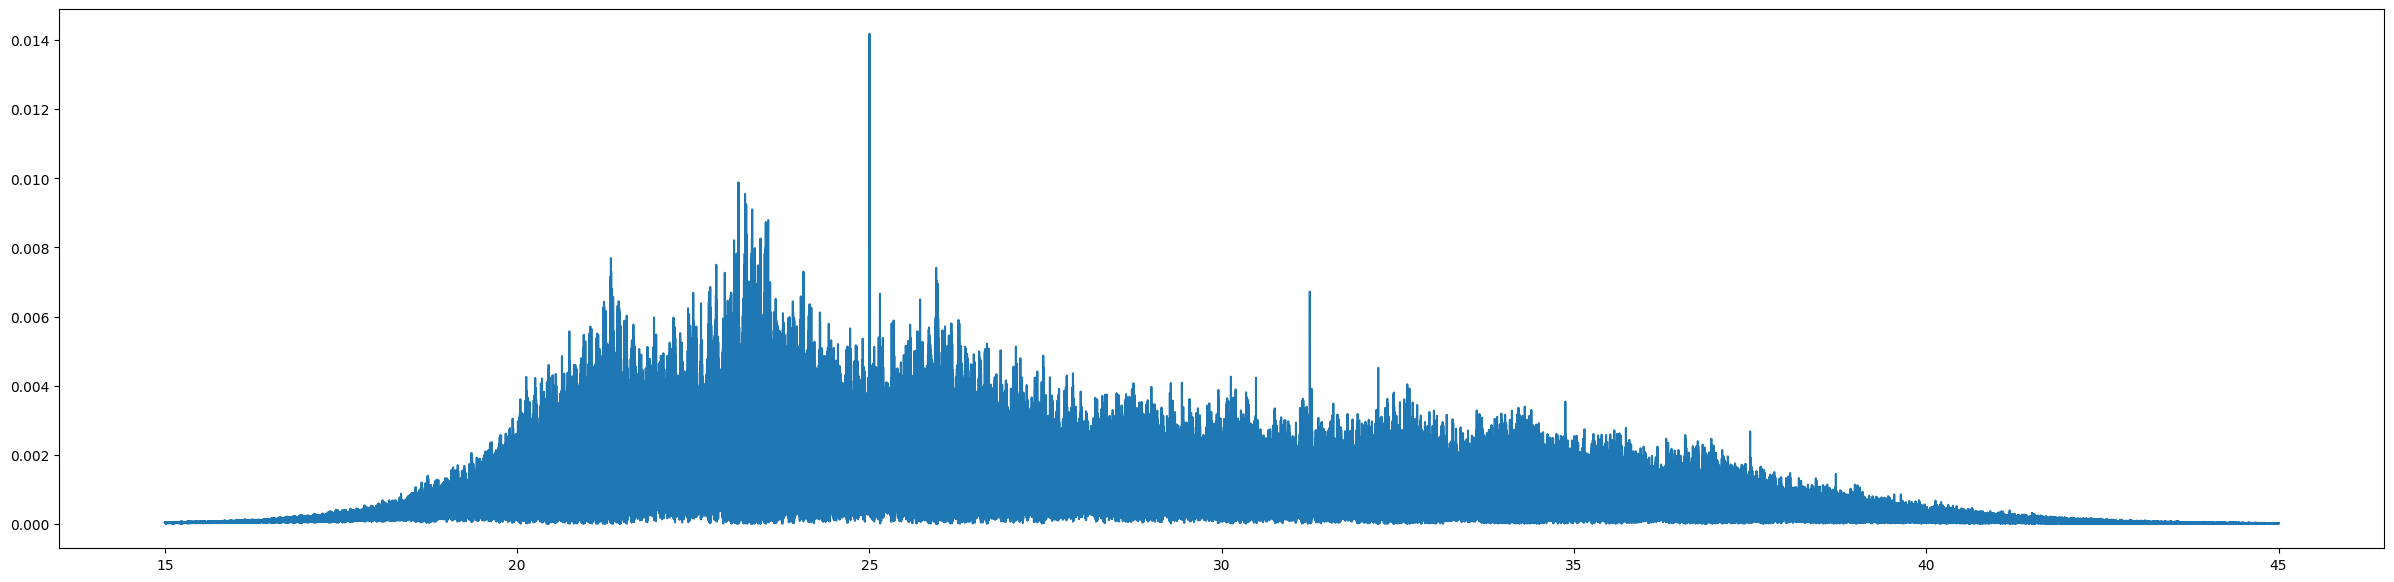

In [242]:
plt.figure(figsize=(30, 7))
plt.plot(idun_time_stamps, idun_filtered_data)
plt.ylim(-200, 200)

id_freqs, id_fft = prepare_fft(idun_filtered_data, FILTER_RANGE[0]-5 ,FILTER_RANGE[1]+5 ,IDUN_SAMPLE_RATE)
plt.figure(figsize=(30, 7))
plt.plot(id_freqs, id_fft)

### Make data same length

In [243]:
prodigy_cleaned_data = prodigy_filtered_data_rs
idun_cleaned_data = idun_filtered_data
# Find which one is longer and how much longer
if len(prodigy_cleaned_data) > len(idun_cleaned_data):
    longer_len = len(prodigy_cleaned_data)
    shorter_len = len(idun_cleaned_data)
    diff = int(longer_len - shorter_len)
    prodigy_cleaned_data = prodigy_cleaned_data[int(diff/2):int(-diff/2)]
else:
    longer_len = len(idun_cleaned_data)
    shorter_len = len(prodigy_cleaned_data)
    diff = int(longer_len - shorter_len)
    idun_cleaned_data = idun_cleaned_data[int(diff/2):int(-diff/2)]
    
same_times = np.linspace(0, len(idun_cleaned_data)/BASE_SAMPLE_RATE, len(idun_cleaned_data))


(-200.0, 200.0)

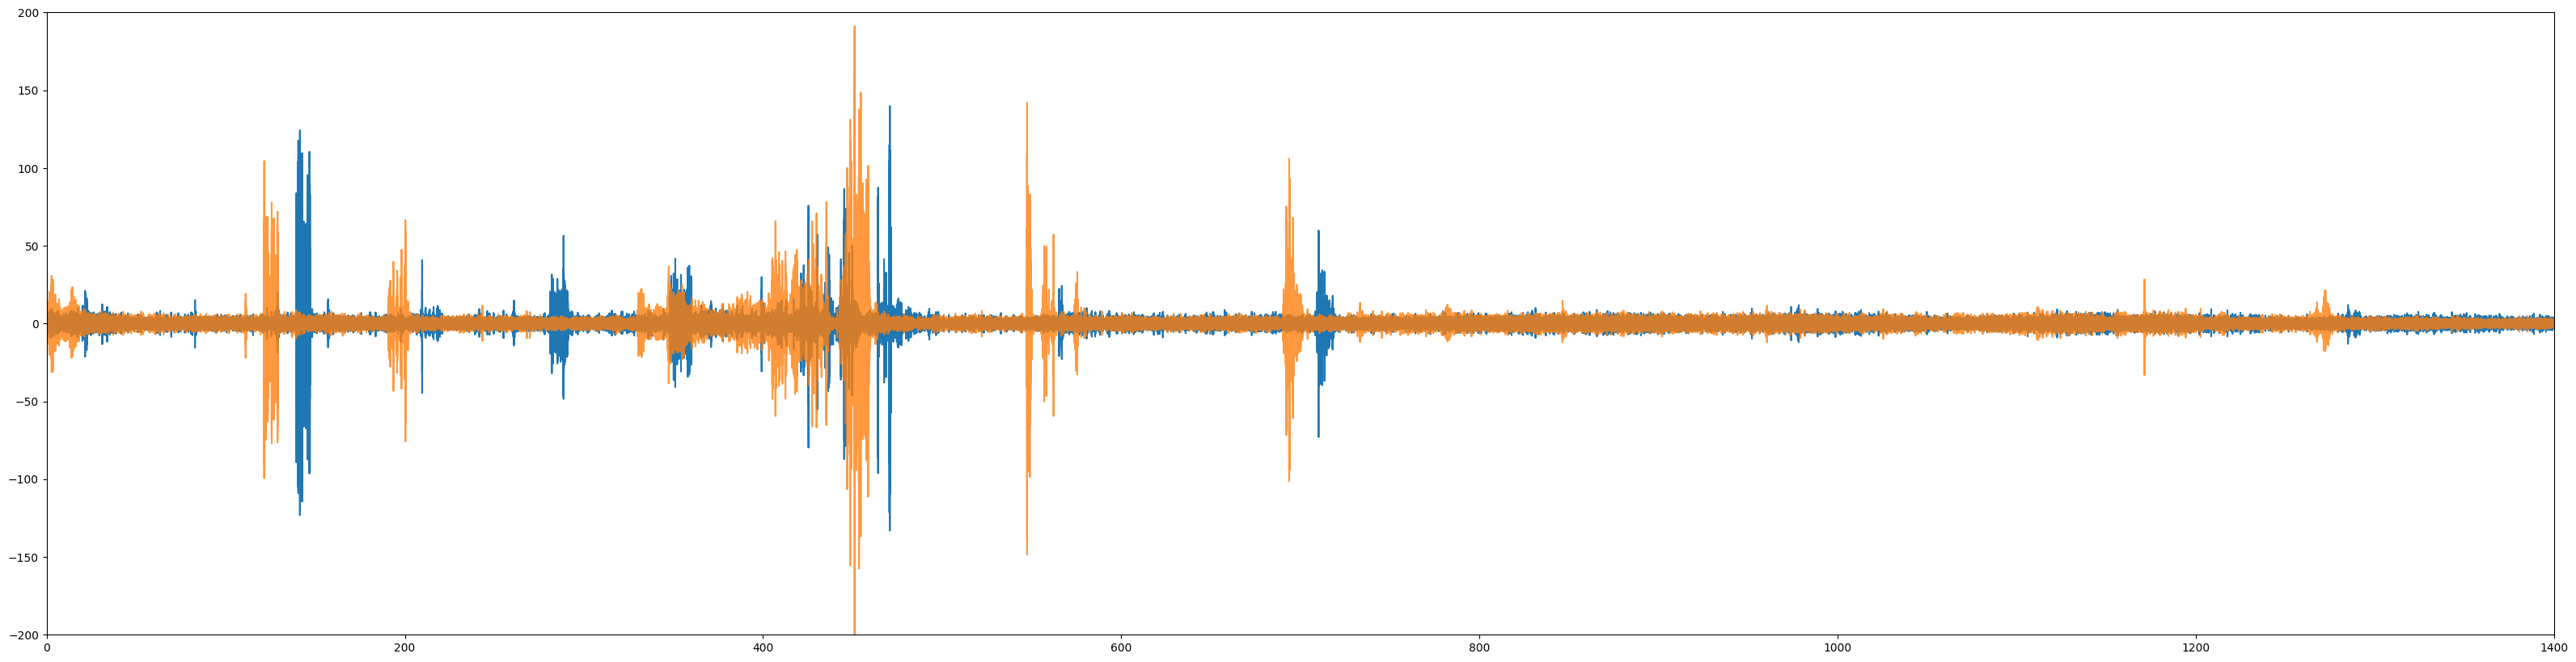

In [244]:
plt.figure(figsize=(40, 10))
plt.plot(same_times, prodigy_cleaned_data)
plt.ylim(-200, 200)
plt.plot(same_times, 0.8*idun_cleaned_data, alpha = 0.8)
plt.xlim(0, 1400)
plt.ylim(-200, 200)

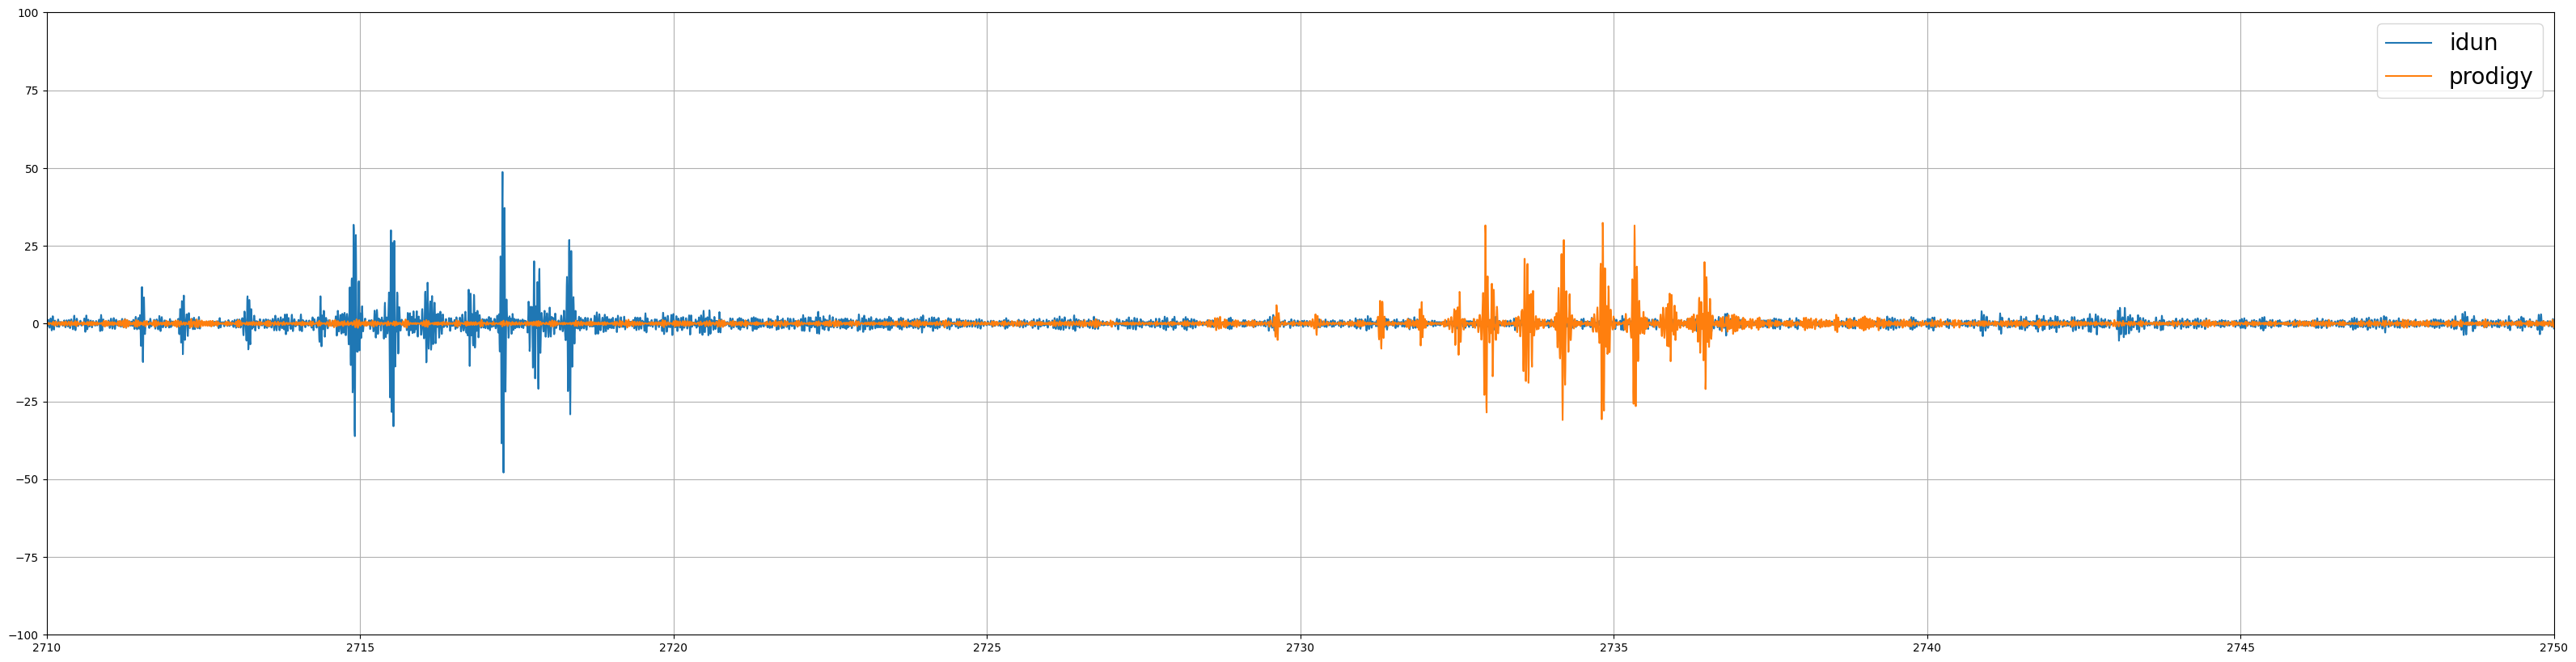

In [245]:
# plot the data
plt.figure(figsize=(40, 10))

plt.plot(same_times,idun_cleaned_data, label='idun')
plt.plot(same_times,0.5*prodigy_cleaned_data, label='prodigy')
plt.xlim(2710, 2750)
plt.legend(fontsize=20)
plt.ylim(-100,100)
plt.grid()

### Calculate lag

In [246]:

prodigy_epochs = epoch_data(prodigy_cleaned_data, FIRST_LAG_EPOCH_SIZE)
idun_epochs = epoch_data(idun_cleaned_data, FIRST_LAG_EPOCH_SIZE)

In [247]:
correlation_arr, max_corr_arr, lag_arr = calculate_epochs_lag(prodigy_epochs, idun_epochs)

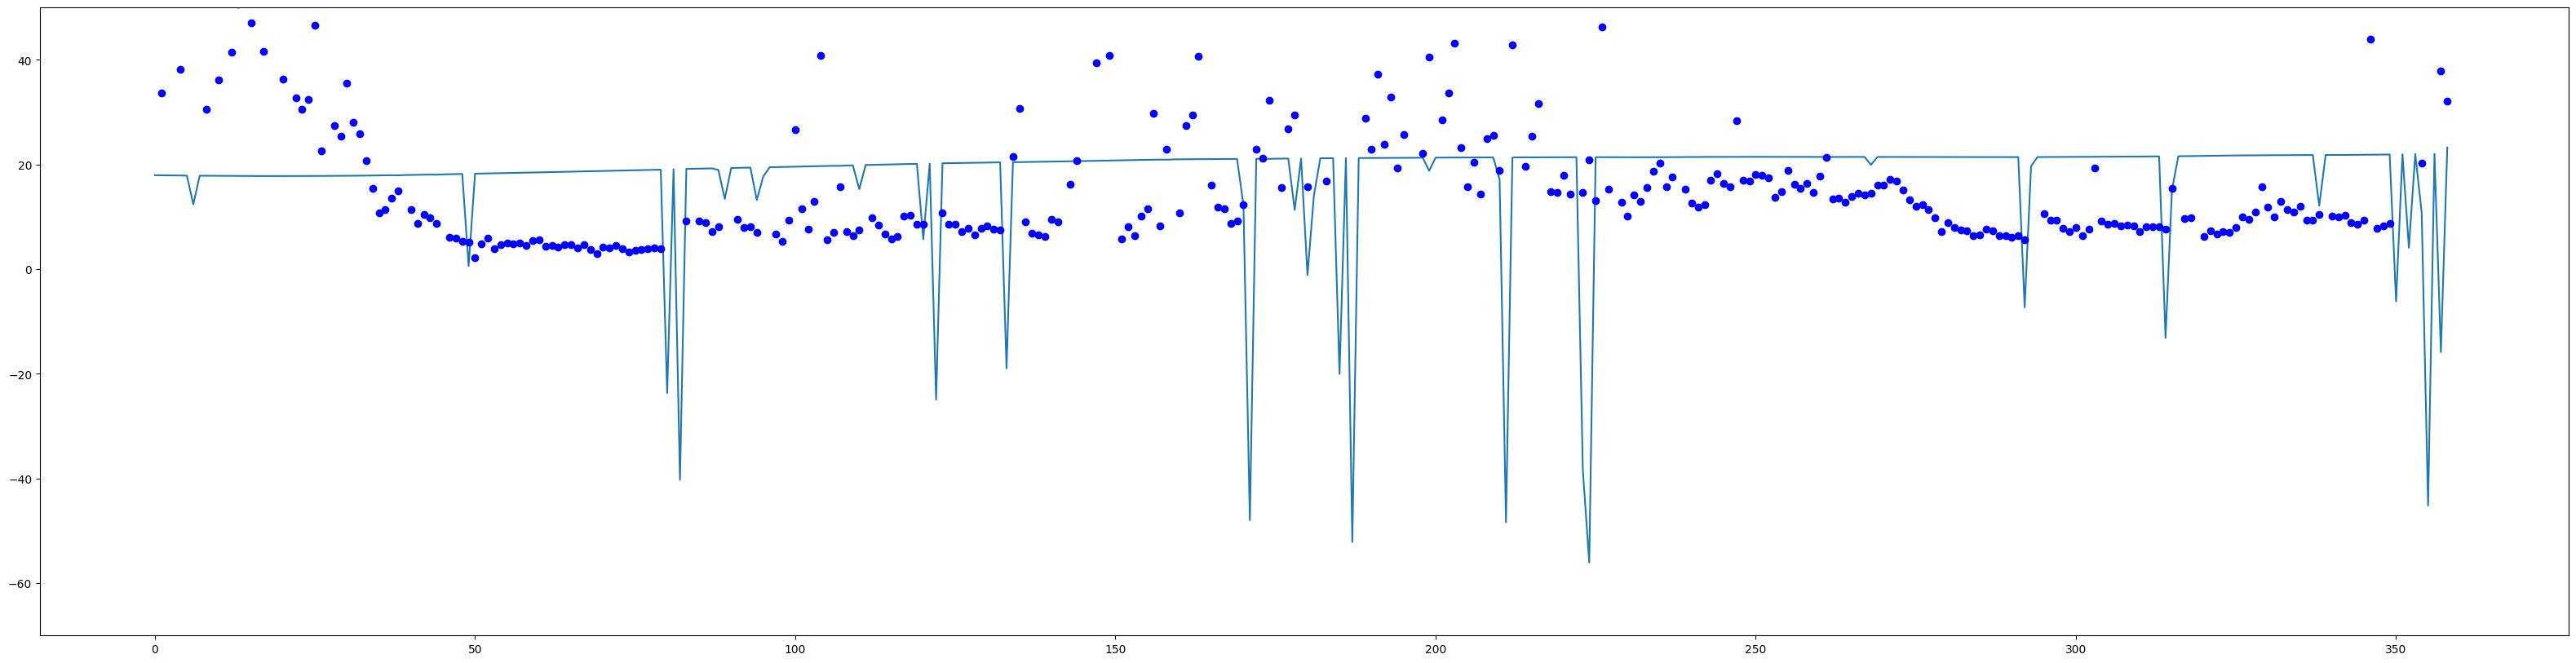

In [248]:
lag_arr_copy = lag_arr[1:].copy()
plt.figure(figsize=(40, 10))
plt.plot(np.array(lag_arr_copy)/250)
plt.plot(np.array(max_corr_arr)/len(lag_arr_copy), 'bo')
plt.ylim(-70,50)
plt.show()

### Cut based on first analysis

lag_mean:  17.96


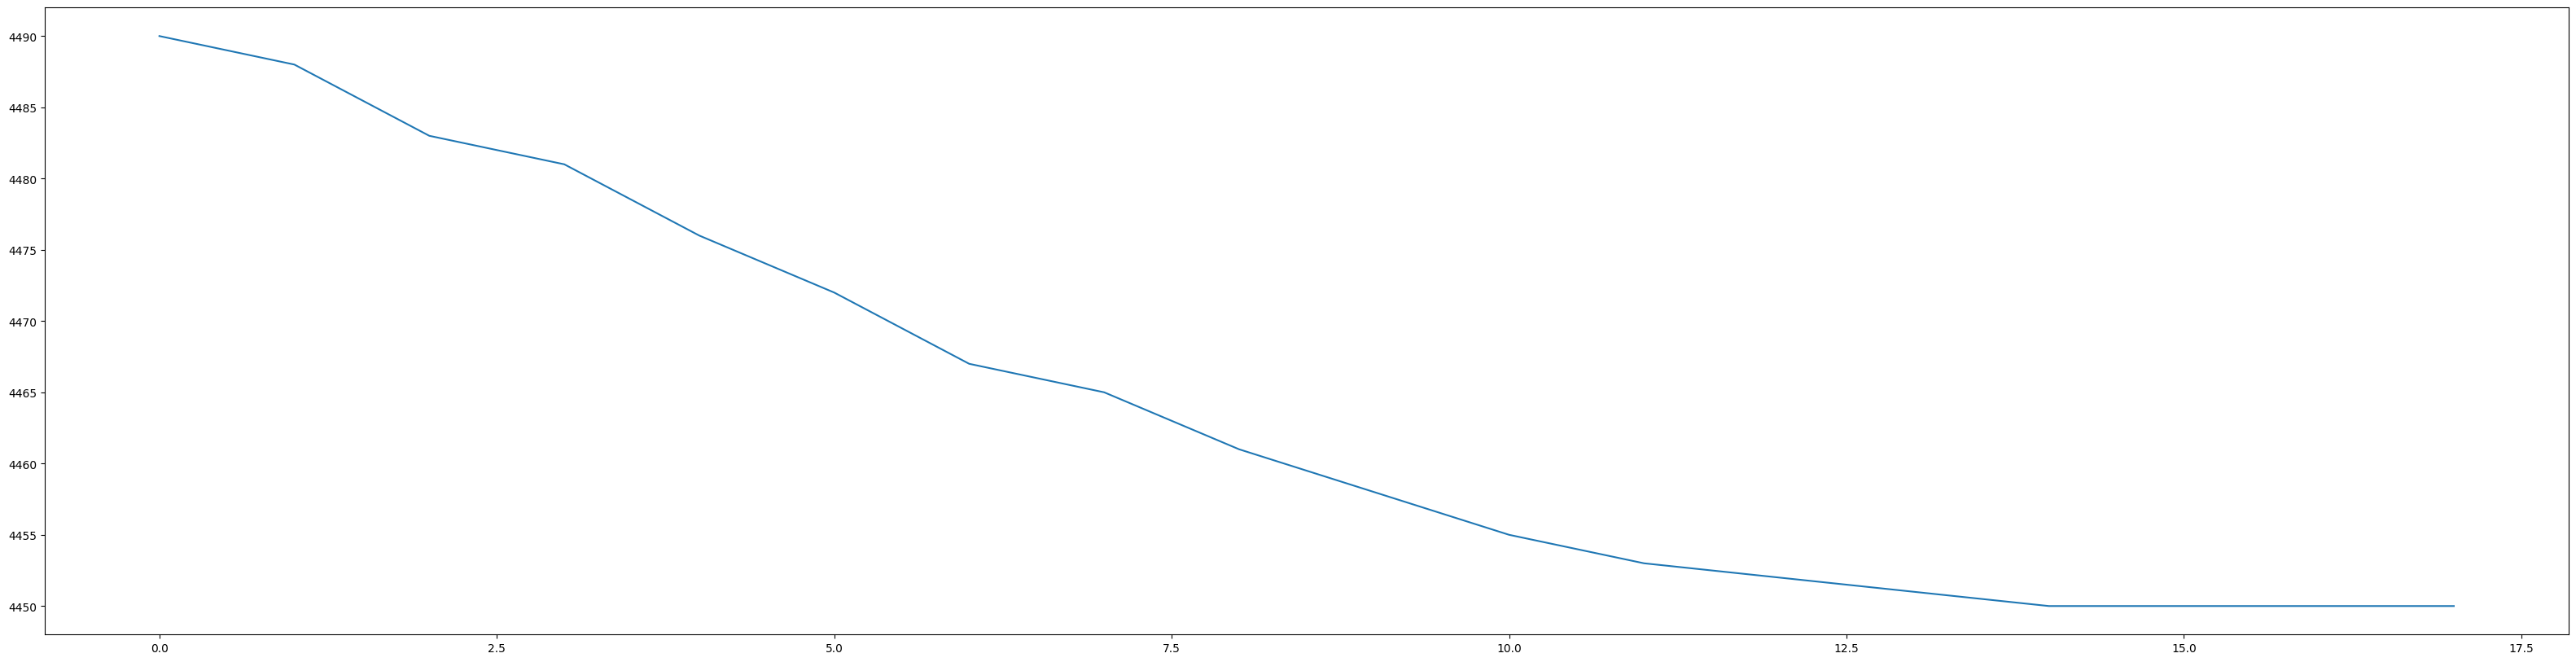

In [303]:
lag_arr = np.array(lag_arr)
lag_initial = lag_arr[:20]
lag_initial = remove_outliers(lag_initial)
lag_mean = lag_initial[0]

# cut the lag_mean data from the start of idun_cleaned_data if it is positive or from the start of prodigy_cleaned_data if negative
if lag_mean < 0:
    idun_cut_data = idun_cleaned_data[lag_mean:]
    prodigy_cut_data = prodigy_cleaned_data[:-(lag_mean)]
else:
    idun_cut_data = idun_cleaned_data[:-(lag_mean)]
    prodigy_cut_data = prodigy_cleaned_data[lag_mean:]

# plot the data
plt.figure(figsize=(40, 10))
# create a  axis
plt.plot(lag_initial, label='idun')

print('lag_mean: ', lag_mean/250)


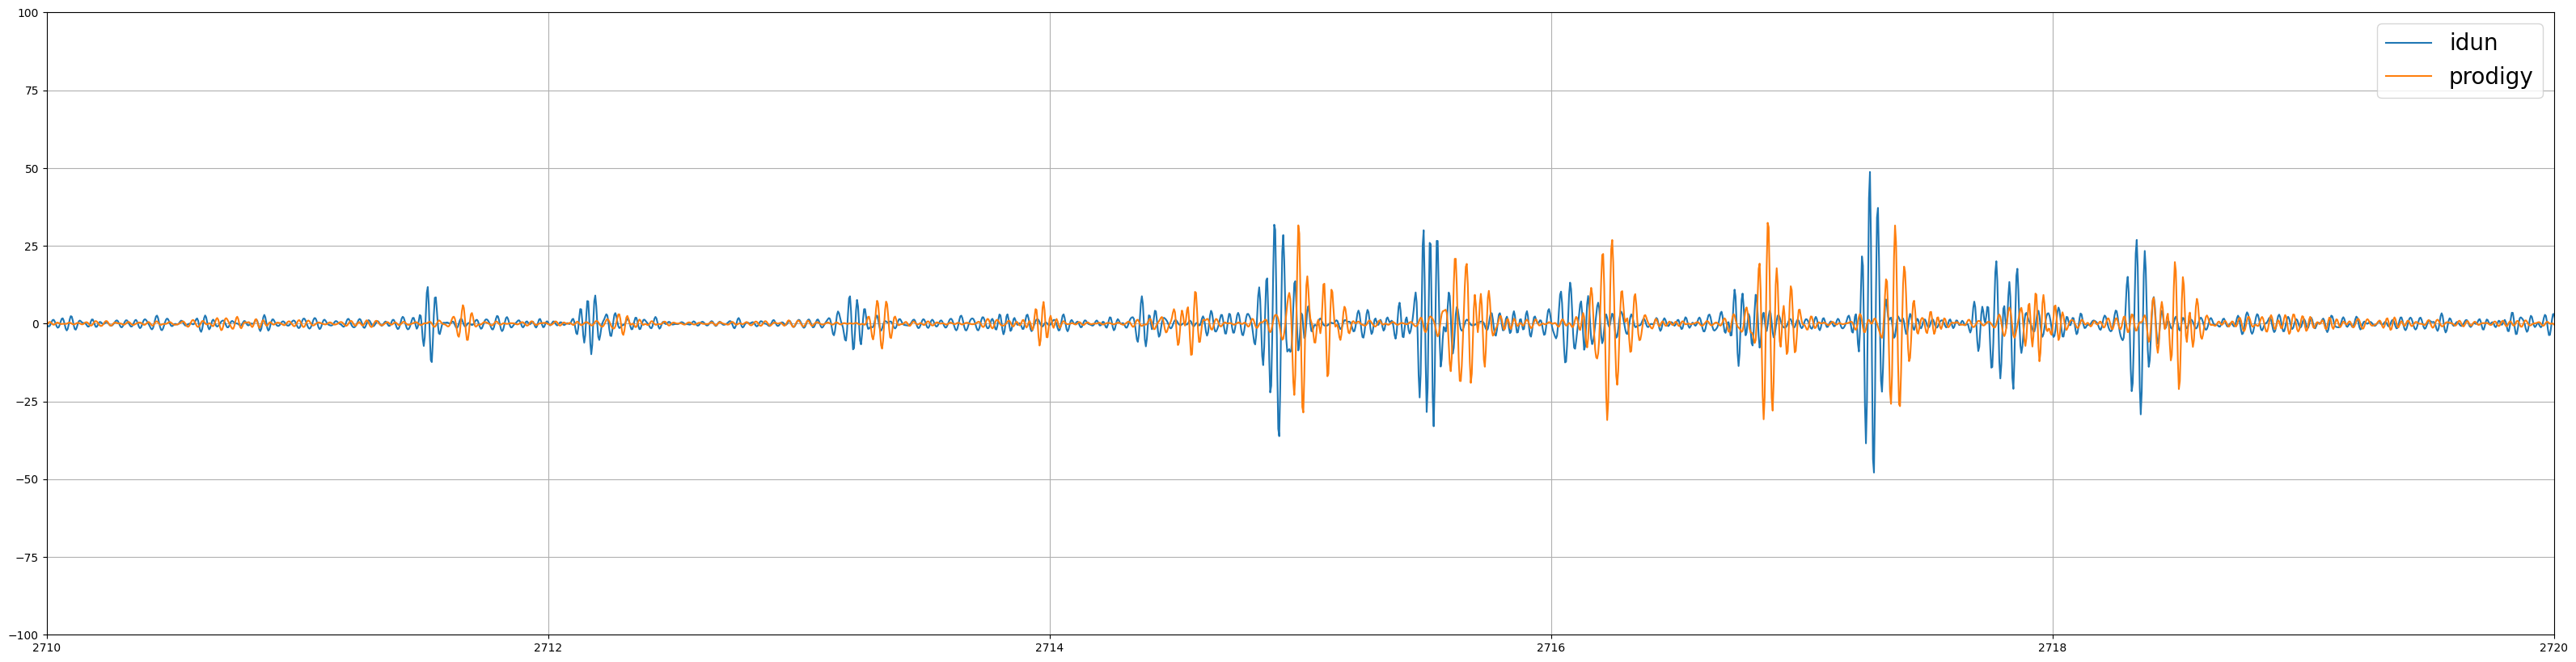

In [304]:
# plot the data
plt.figure(figsize=(40, 10))
# create a seconds axis
time_seconds = np.arange(len(idun_cut_data))/BASE_SAMPLE_RATE
plt.plot(time_seconds,idun_cut_data, label='idun')
plt.plot(time_seconds,0.5*prodigy_cut_data, label='prodigy')
plt.xlim(2710, 2720)
plt.legend(fontsize=20)
plt.ylim(-100,100)
plt.grid()

### Do a more fine grained sync

In [305]:

cutted_prodigy_epochs = epoch_data(prodigy_cut_data, SECOND_LAG_EPOCH_SIZE)
cutted_idun_epochs = epoch_data(idun_cut_data, SECOND_LAG_EPOCH_SIZE)

In [306]:
fine_correlation_arr, fine_max_corr_arr, fine_lag_arr = calculate_epochs_lag(cutted_prodigy_epochs, cutted_idun_epochs)

(-1.0, 5.0)

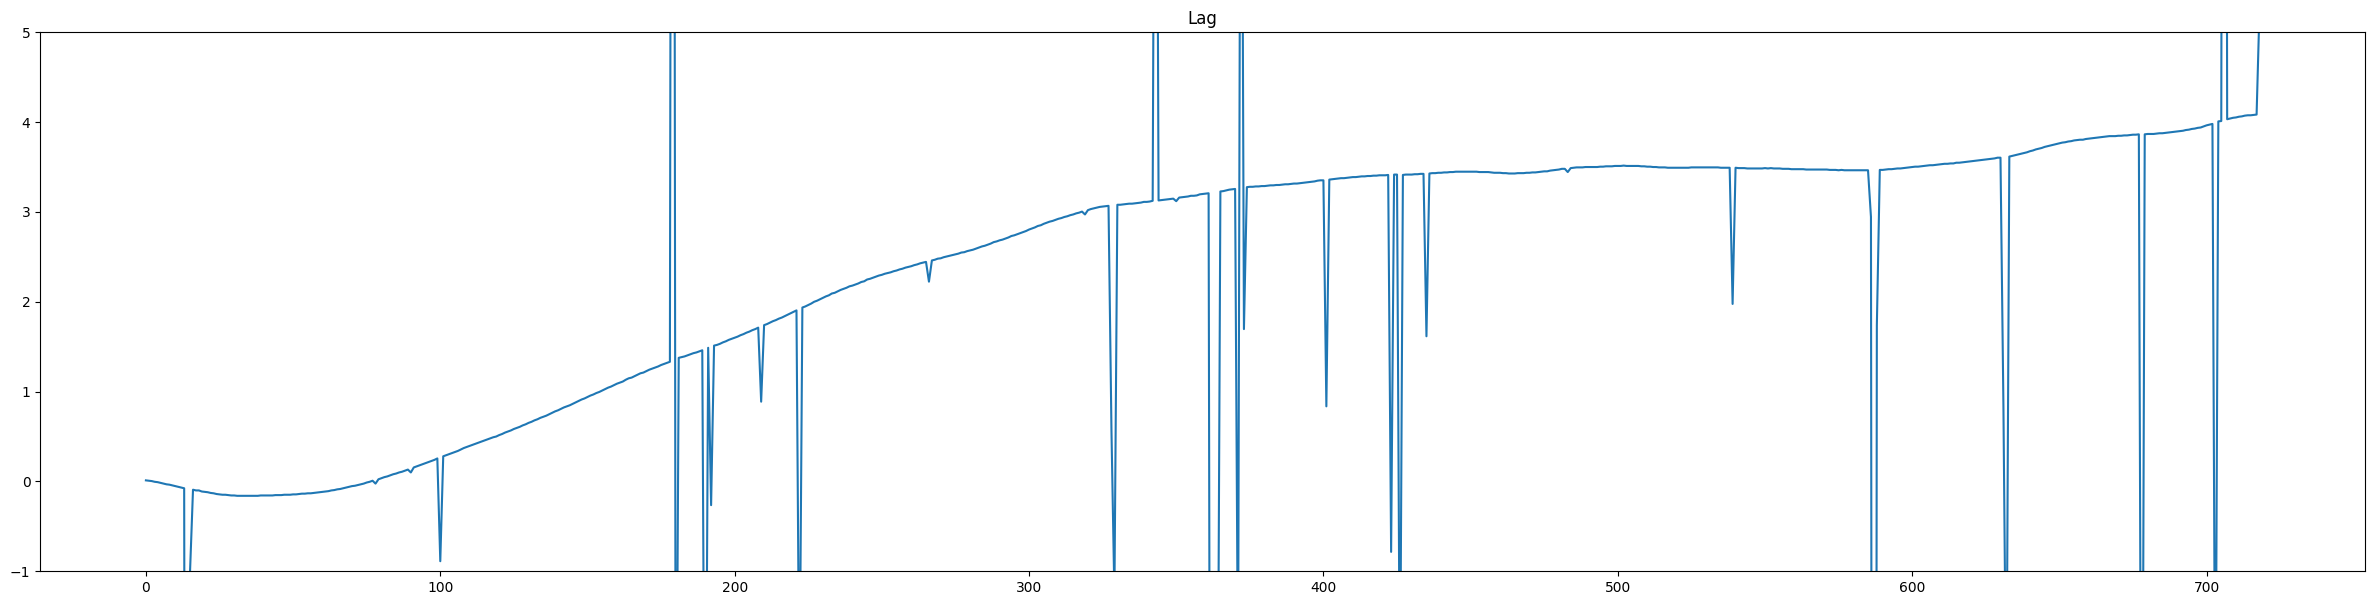

In [307]:
fine_lag_arr_copy = fine_lag_arr.copy()
plt.figure(figsize=(30, 7))
plt.plot(np.array(fine_lag_arr_copy)/250)
plt.title('Lag')
plt.ylim(-1,5)

### Do some cleaning

719

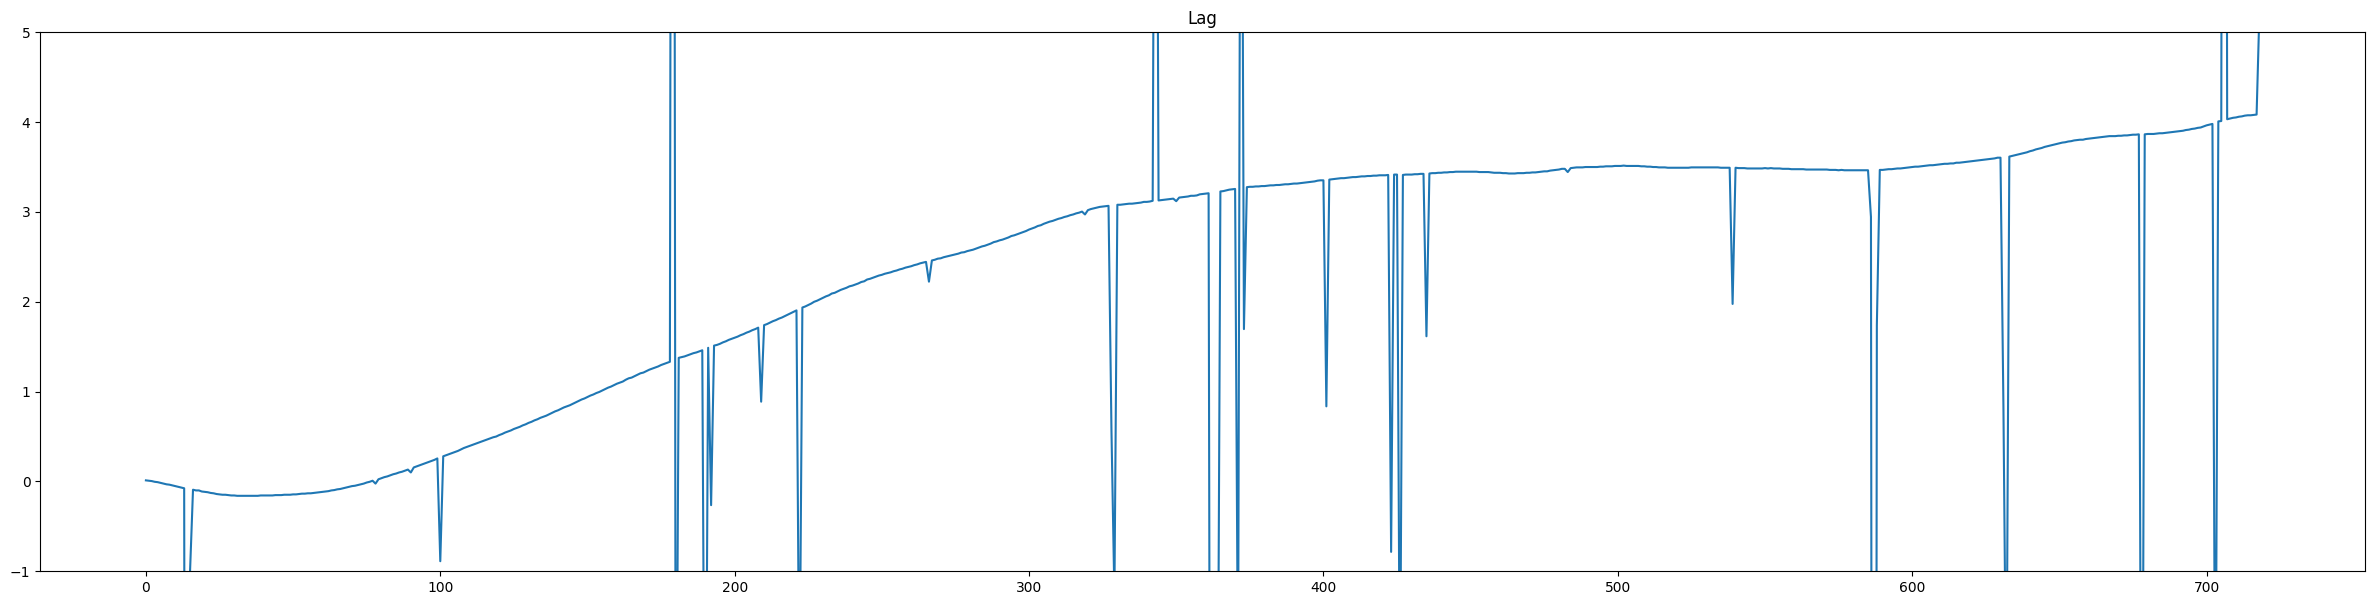

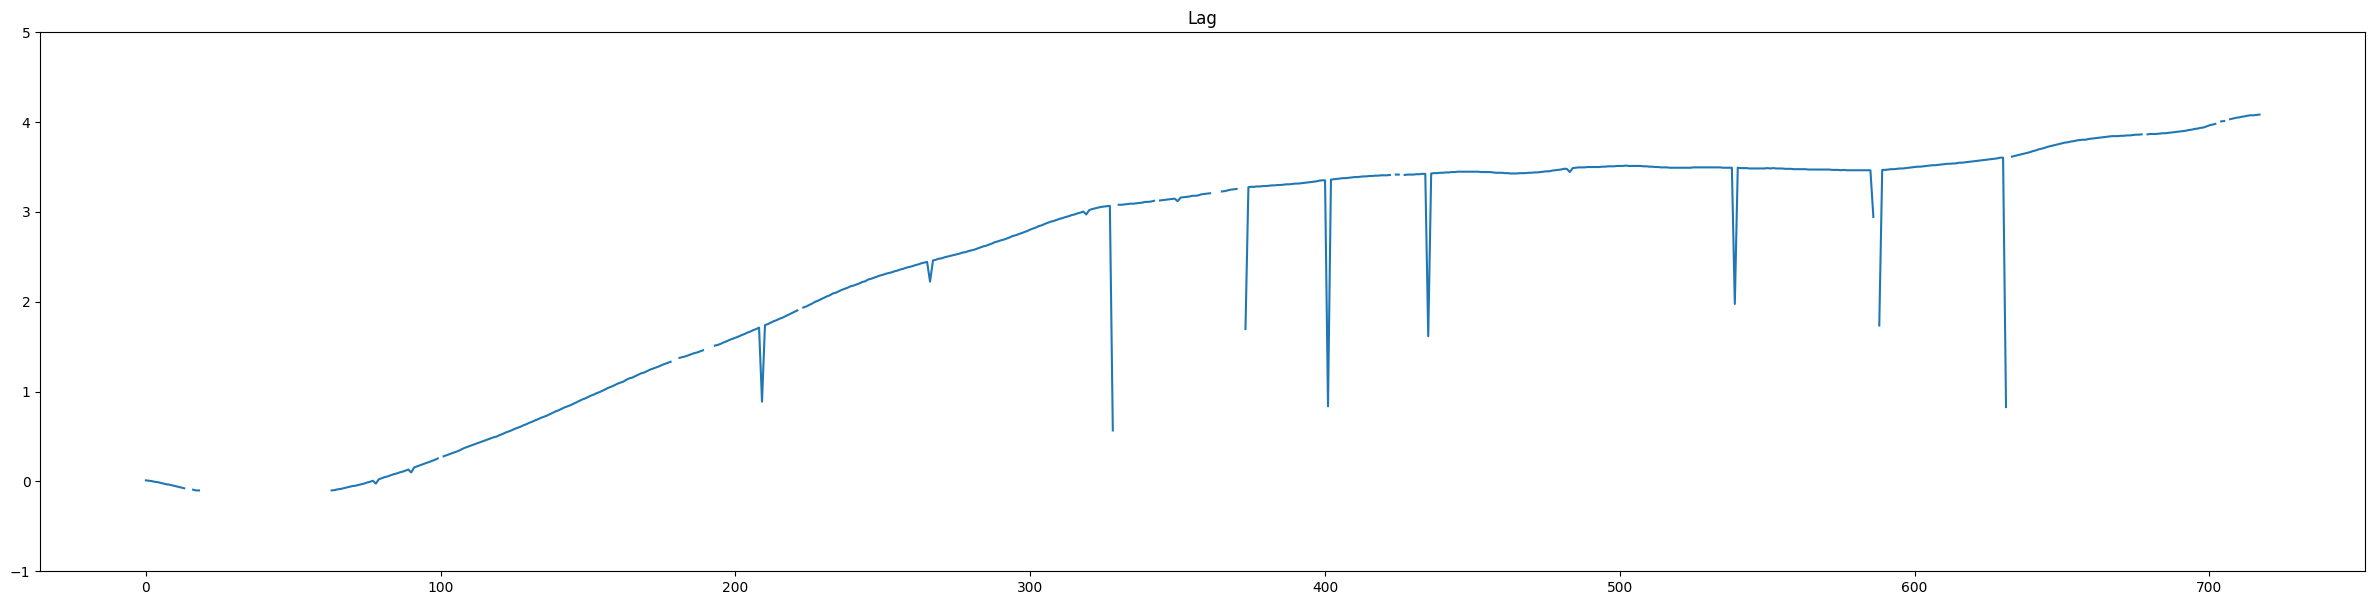

In [308]:
cleaned_fine_lag_arr = replace_outliers(fine_lag_arr_copy)
# Assuming the above code, we just continue:
plt.figure(figsize=(30, 7))
#plt.plot(np.array(fine_lag_arr_copy)/250)
plt.plot(np.array(fine_lag_arr_copy)/250)
plt.title('Lag')
plt.ylim(-1,5)

plt.figure(figsize=(30, 7))
#plt.plot(np.array(fine_lag_arr_copy)/250)
plt.plot(np.array(cleaned_fine_lag_arr)/250)
plt.title('Lag')
plt.ylim(-1,5)
len(cleaned_fine_lag_arr)


### Fit a curve to the data

In [309]:

original_raw_lag = copy.deepcopy(cleaned_fine_lag_arr)
X = np.arange(len(cleaned_fine_lag_arr)).reshape(-1, 1)
X_copy = X.copy()
# find where y is not nan
not_nan_idx = np.where(~np.isnan(original_raw_lag))[0]
original_raw_lag = original_raw_lag[not_nan_idx]
X = X[not_nan_idx]

# Transform the features to 2nd degree polynomial features
poly = PolynomialFeatures(degree=5)
X_poly = poly.fit_transform(X)
# Create a LinearRegression model and fit it to the polynomial features
reg = LinearRegression().fit(X_poly, original_raw_lag)
# Predict values
X_new_poly = poly.transform(X_copy)
linear_regression_lag = reg.predict(X_new_poly)


In [310]:
len(linear_regression_lag)

719

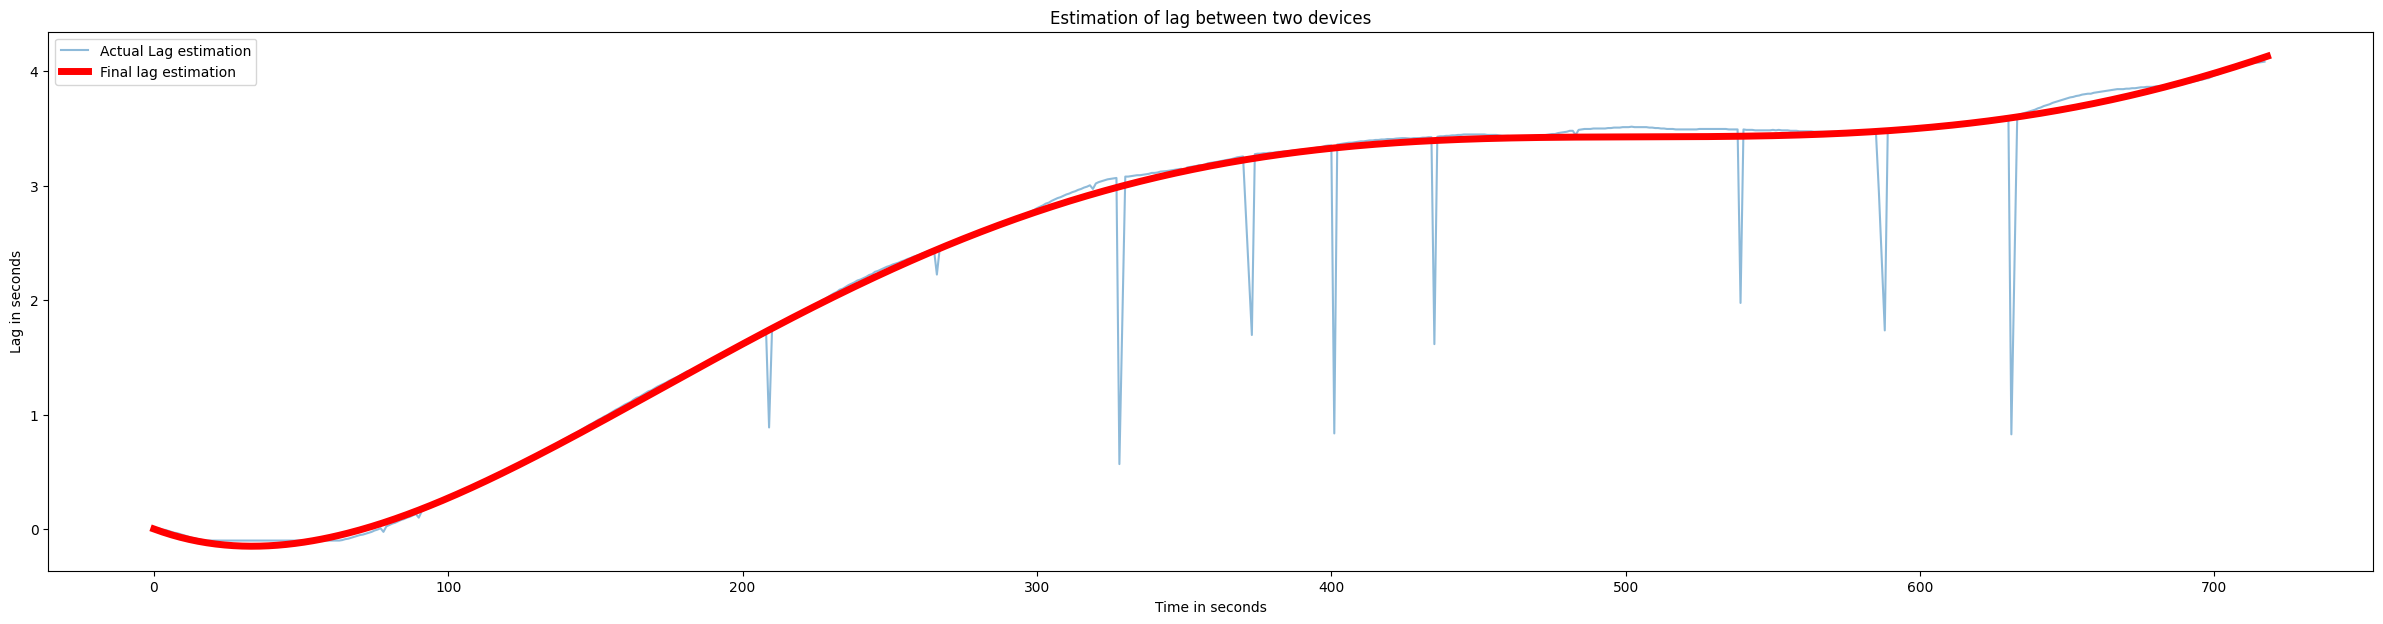

In [311]:
# Plotting the regression curve
plt.figure(figsize=(30, 7))
plt.plot(X, original_raw_lag/250, label='Actual Lag estimation', alpha=0.5)
plt.plot(X_copy, linear_regression_lag/250, "r-", label="Final lag estimation", linewidth=5)
plt.title("Estimation of lag between two devices")
plt.xlabel("Time in seconds")
plt.ylabel("Lag in seconds")
plt.legend()
plt.show()

In [312]:
x = np.linspace(0, len(linear_regression_lag)-1, len(linear_regression_lag))  # This will be 0 to 718
# Approximate with N linear segments
x_knots = np.linspace(0, len(linear_regression_lag)-1, TOTAL_LINEAR_SEGMENTS+1)
y_knots = linear_regression_lag[(x_knots).astype(int)]  # Directly get the y-values from y_pred

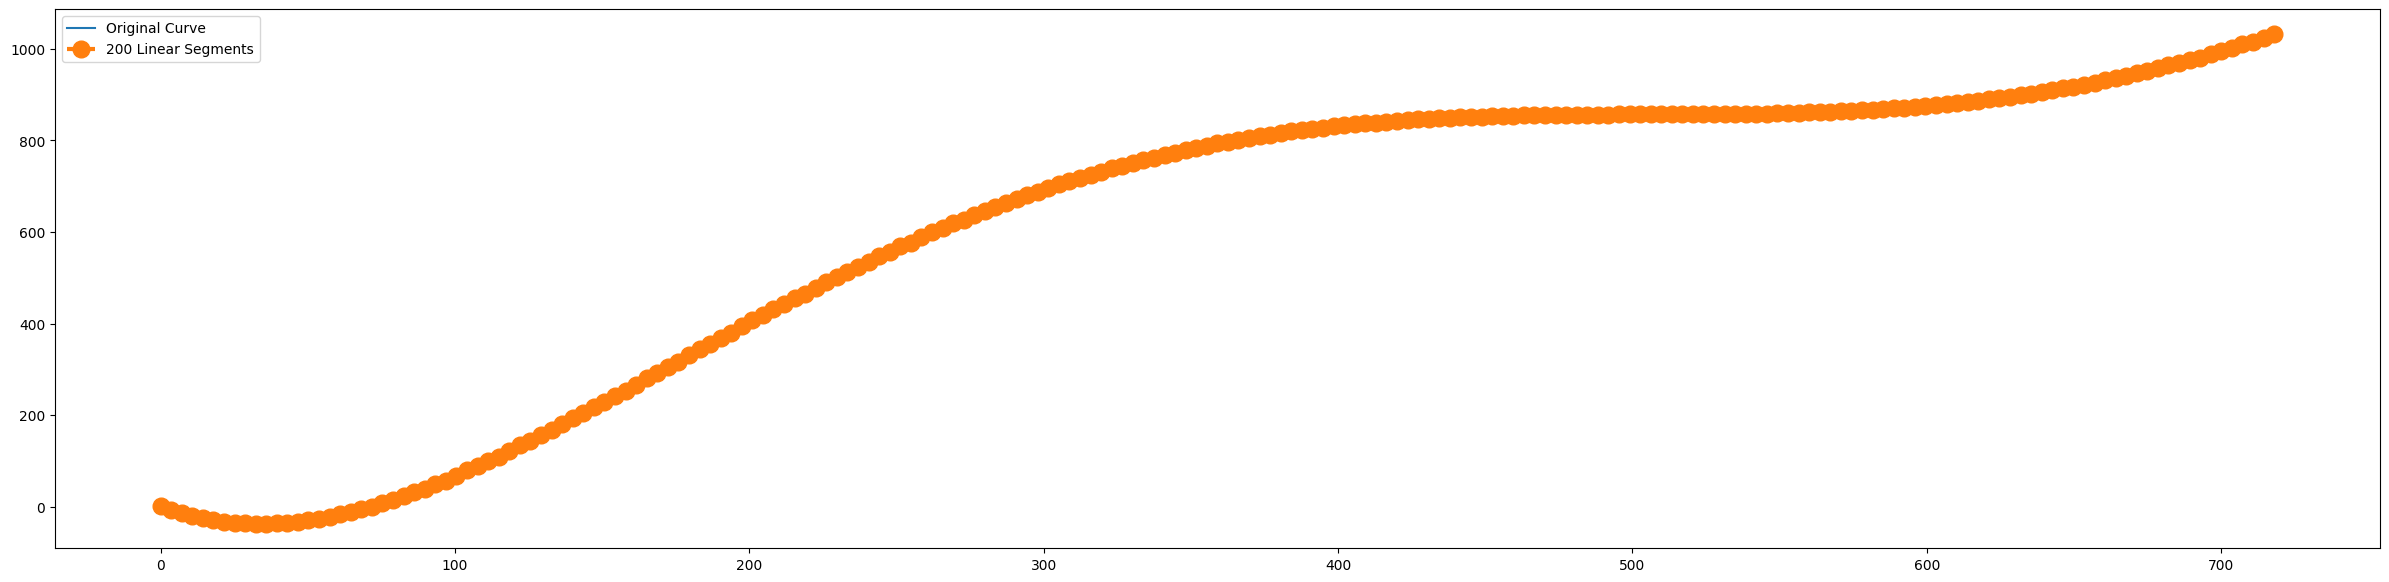

In [314]:
# Plot
plt.figure(figsize=(30, 7))
plt.plot(x, linear_regression_lag, label='Original Curve')
plt.plot(x_knots, y_knots, label=f'{TOTAL_LINEAR_SEGMENTS} Linear Segments', linestyle='--', marker='o', linewidth=3, markersize=12)
plt.legend()
plt.show()

In [315]:
y_knots[0]/250

0.0014862625585647037

### Use the Linear lines to estimate the difference in sampling rates and apply

Text(0.5, 1.0, 'Number of samples to be removed at each lag')

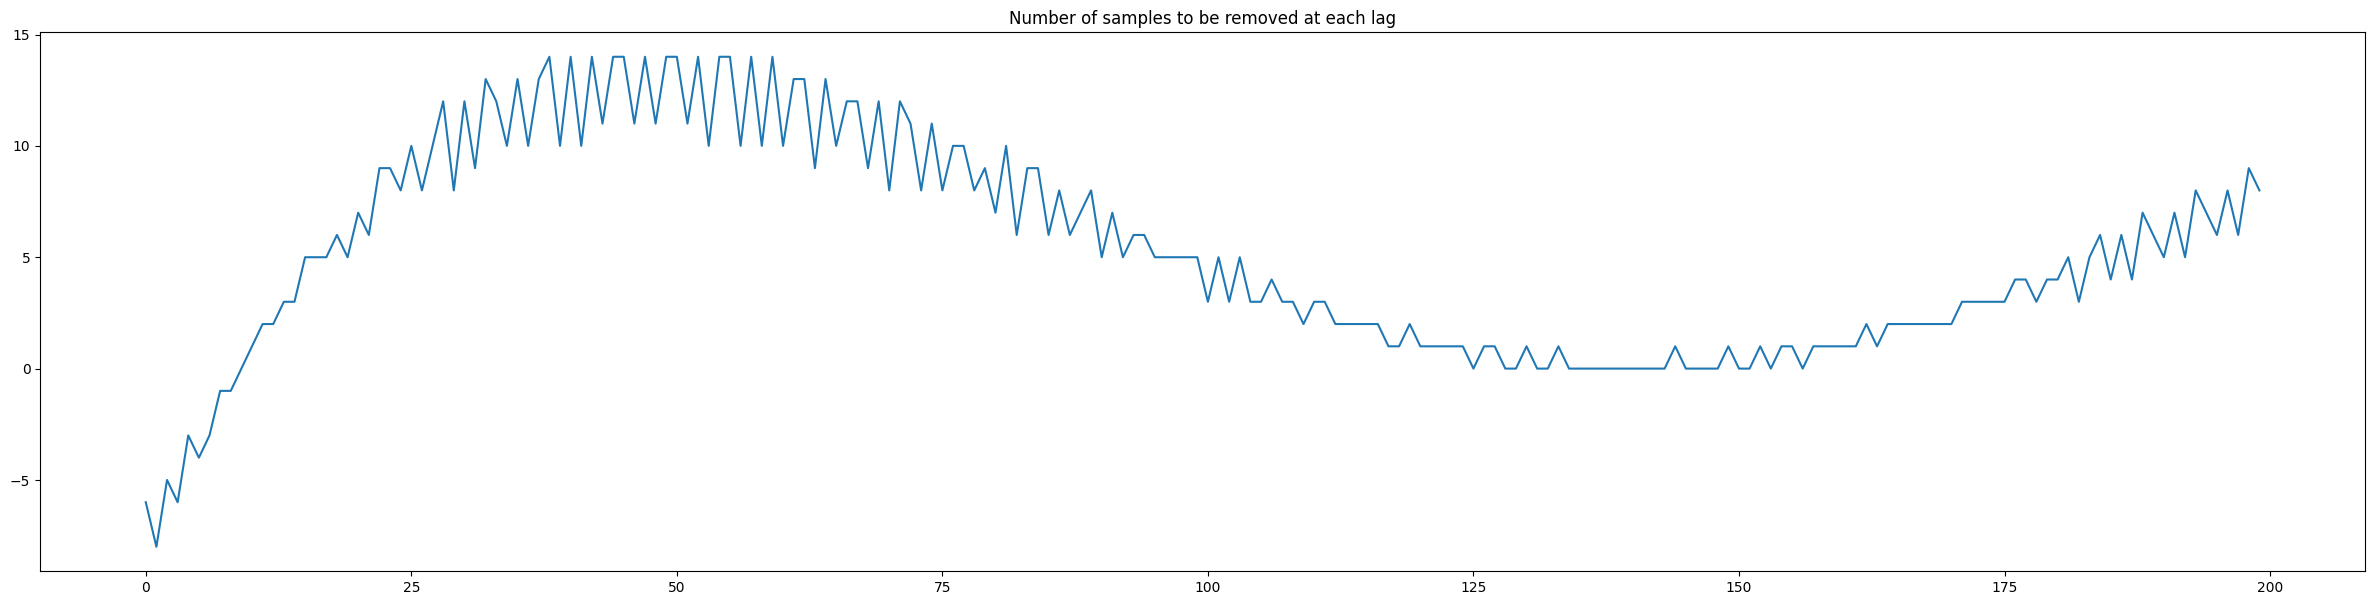

In [329]:
point_size = SECOND_LAG_EPOCH_SIZE
adjustment_epoch_size = int(len(prodigy_cut_data)/TOTAL_LINEAR_SEGMENTS)
lag_positions = np.arange(0, len(prodigy_cut_data), adjustment_epoch_size)
cumulative_lags = y_knots.astype(int)
# amount of sample to be removed at each lag
lag_sizes = np.diff(cumulative_lags)
plt.figure(figsize=(30, 7))
plt.plot(lag_sizes)
plt.title("Number of samples to be removed at each lag")

In [330]:
dataset2 = copy.deepcopy(prodigy_cut_data)
dataset2_list = dataset2.tolist()
 
for i in range(len(lag_positions)):
    start_index = lag_positions[i]
    
    # Calculate how many elements to replace with np.nan
    if i == 0:
        n_replace = cumulative_lags[i]
    else:
        n_replace = cumulative_lags[i] - cumulative_lags[i-1]
    for j in range(n_replace):
        if start_index+j < len(dataset2_list):
            
            dataset2_list[start_index+j] = np.nan

# Convert back to numpy array and remove np.nan values
adjusted_dataset2 = np.array(dataset2_list)
adjusted_dataset2 = adjusted_dataset2[~np.isnan(adjusted_dataset2)]
prodigy_adjusted_final_arr = np.array(adjusted_dataset2)
idun_adjusted_final_arr = np.array(idun_cut_data)

# Cut from the the end of the longer dataset, prodigy_adjusted_final_arr or idun_cut_data, whichever is longer
if len(prodigy_adjusted_final_arr) > len(idun_cut_data):
    prodigy_adjusted_final_arr = prodigy_adjusted_final_arr[:len(idun_adjusted_final_arr)]
else:
    idun_adjusted_final_arr = idun_adjusted_final_arr[:len(prodigy_adjusted_final_arr)]

In [331]:
final_prodigy_epochs = epoch_data(prodigy_adjusted_final_arr, SECOND_LAG_EPOCH_SIZE)
final_idun_epochs = epoch_data(idun_adjusted_final_arr, SECOND_LAG_EPOCH_SIZE)

In [332]:
final_correlation_arr, final_max_corr_arr, final_lag_arr = calculate_epochs_lag(final_prodigy_epochs, final_idun_epochs)

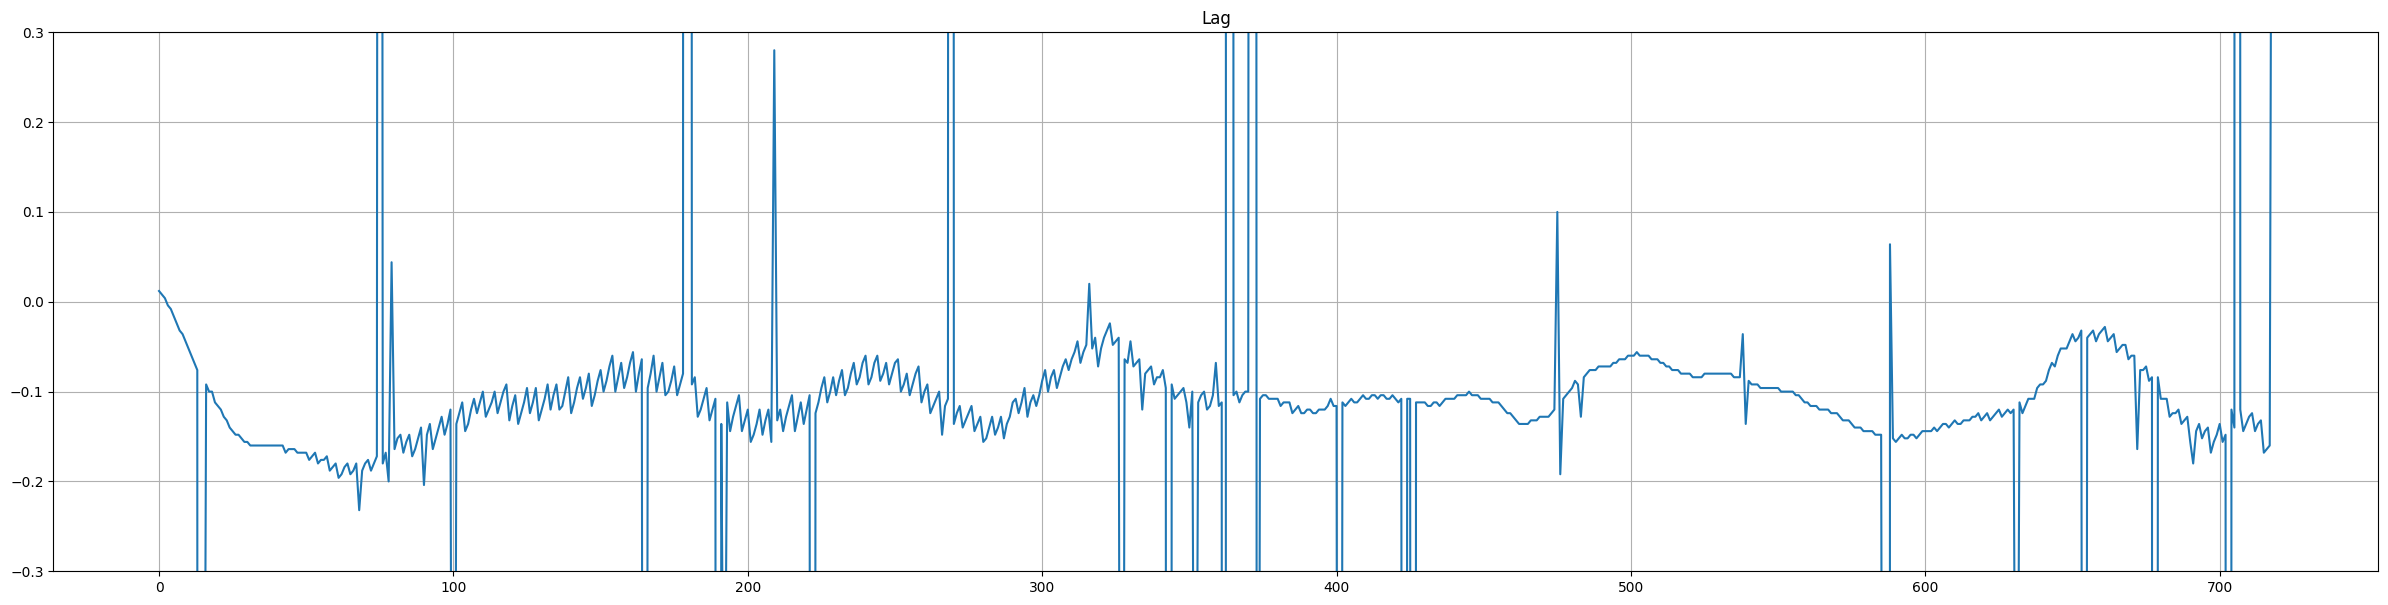

In [ ]:
final_lag_arr_copy = final_lag_arr.copy()
plt.figure(figsize=(30, 7))
plt.plot(np.array(final_lag_arr)/250)
plt.title('Lag')
plt.ylim(-0.3,0.3)
plt.grid()

### Plot final data

/Users/waddaben/.local/share/virtualenvs/idn-sync-data-pWEap7XJ/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/waddaben/.local/share/virtualenvs/idn-sync-data-pWEap7XJ/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


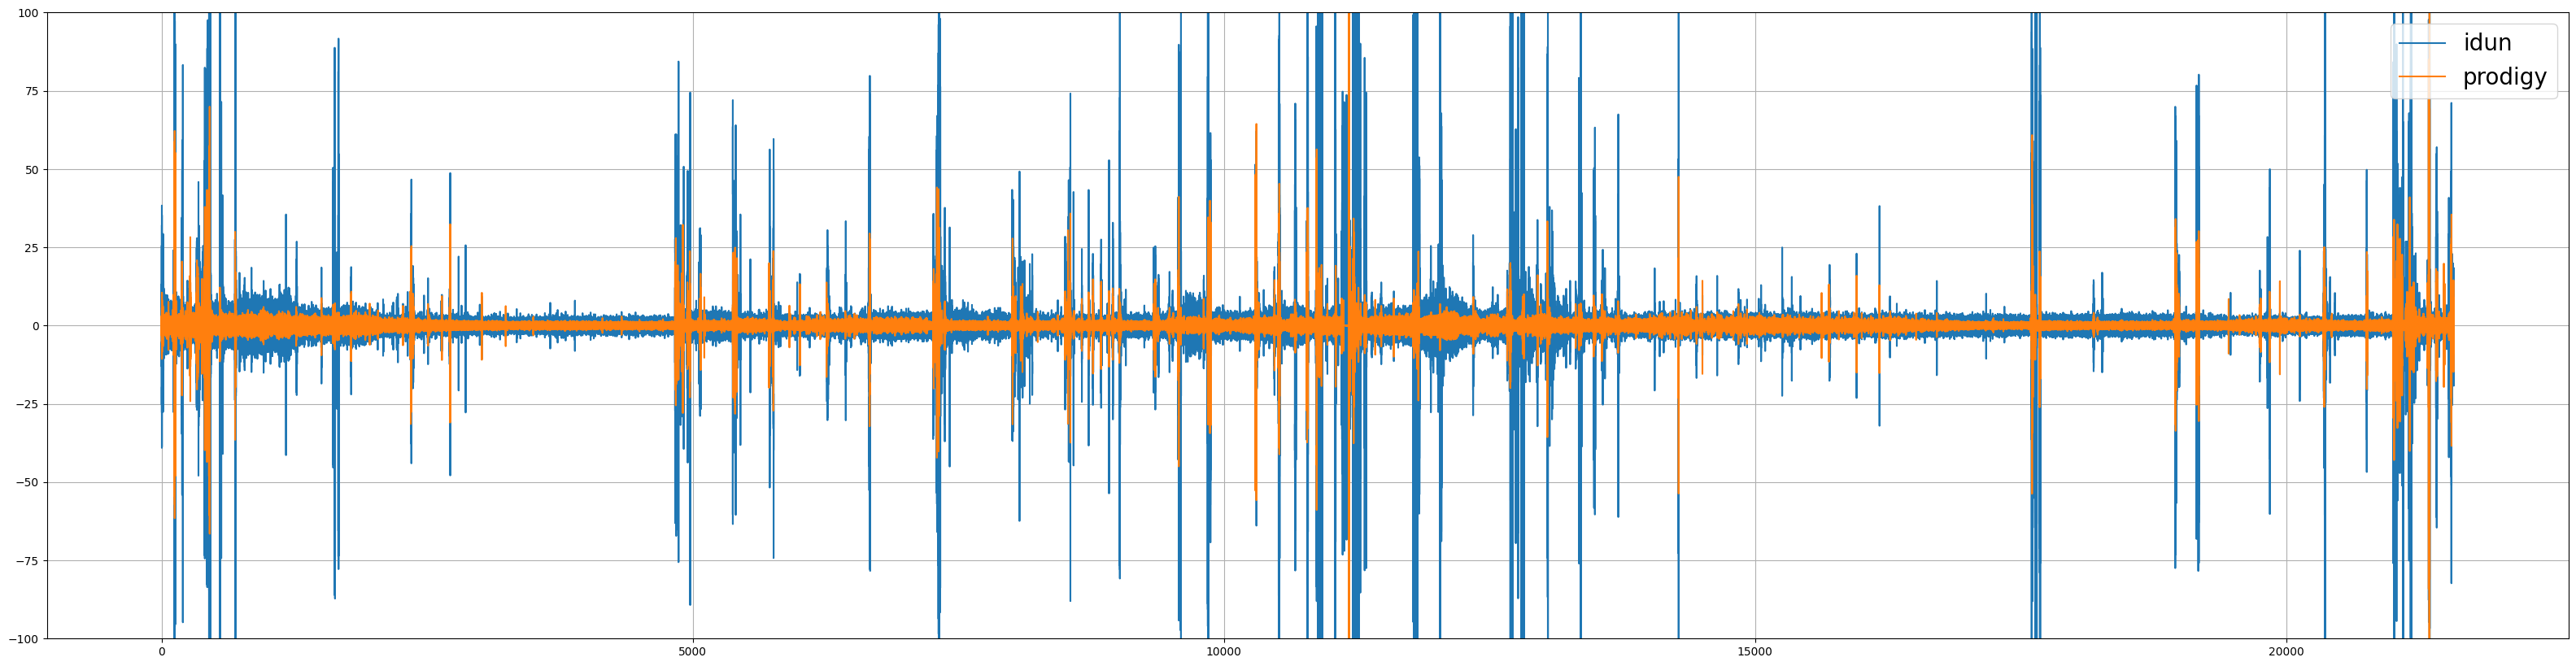

In [ ]:
plt.figure(figsize=(40, 10))
# create a seconds axis
time_seconds = np.arange(len(idun_adjusted_final_arr))/BASE_SAMPLE_RATE
plt.plot(time_seconds,idun_adjusted_final_arr, label='idun')
plt.plot(time_seconds,0.5*prodigy_adjusted_final_arr, label='prodigy')
plt.legend(fontsize=20)
plt.ylim(-100,100)
plt.grid()

In [ ]:
plt.figure(figsize=(40, 10))
# create a seconds axis
time_seconds = np.arange(len(idun_adjusted_final_arr))/BASE_SAMPLE_RATE
plt.plot(time_seconds,idun_adjusted_final_arr, label='idun')
plt.plot(time_seconds,0.5*prodigy_adjusted_final_arr, label='prodigy')
plt.legend(fontsize=20)
plt.ylim(-100,100)
plt.grid()